# DATA COLLECTION

In [1]:
import numpy as np #untuk mengolah angka 
import pandas as pd #untuk mengolah tabel
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns

color = sns.color_palette()
sns.set_style('darkgrid')

kurs = pd.read_csv('USD_IDR (Weekly).csv', index_col='Date') #membaca dataset dengan atribut 'Date' sebagai index awal
kurs = kurs[::-1] #untuk mereserve data
kurs.head()

,Close,Open,High,Low,Change
Date,,,,,
3/5/1998,9300.0,8100.0,10100.0,8000.0,0.1517
10/5/1998,10700.0,9800.0,12300.0,9500.0,0.1505
17/05/1998,11850.0,11200.0,14500.0,10500.0,0.1075
24/05/1998,11450.0,11500.0,11950.0,10000.0,-0.0338
31/05/1998,11700.0,11350.0,11970.0,10400.0,0.0218


# DATA PREPROCESSING

In [2]:
kurs['Close_t1'] = kurs['Close'] #untuk menambahkan kolom Close_t1 
kurs.head()

,Close,Open,High,Low,Change,Close_t1
Date,,,,,,
3/5/1998,9300.0,8100.0,10100.0,8000.0,0.1517,9300.0
10/5/1998,10700.0,9800.0,12300.0,9500.0,0.1505,10700.0
17/05/1998,11850.0,11200.0,14500.0,10500.0,0.1075,11850.0
24/05/1998,11450.0,11500.0,11950.0,10000.0,-0.0338,11450.0
31/05/1998,11700.0,11350.0,11970.0,10400.0,0.0218,11700.0


In [3]:
## Penggeseran kolom ke bawah (except kolom Close_t1) 
kurs['Close'] = kurs['Close'].shift(1)
kurs['Open'] = kurs['Open'].shift(1, axis = 0) 
kurs['High'] = kurs['High'].shift(1, axis = 0) 
kurs['Low'] = kurs['Low'].shift(1, axis = 0)
kurs['Change'] = kurs['Change'].shift(1, axis = 0) 
kurs.head()

,Close,Open,High,Low,Change,Close_t1
Date,,,,,,
3/5/1998,NaN,NaN,NaN,NaN,NaN,9300.0
10/5/1998,9300.0,8100.0,10100.0,8000.0,0.1517,10700.0
17/05/1998,10700.0,9800.0,12300.0,9500.0,0.1505,11850.0
24/05/1998,11850.0,11200.0,14500.0,10500.0,0.1075,11450.0
31/05/1998,11450.0,11500.0,11950.0,10000.0,-0.0338,11700.0


In [4]:
#Penghapusan baris teratas yang bernilai NaN
kurs = kurs.dropna()
kurs.head()

,Close,Open,High,Low,Change,Close_t1
Date,,,,,,
10/5/1998,9300.0,8100.0,10100.0,8000.0,0.1517,10700.0
17/05/1998,10700.0,9800.0,12300.0,9500.0,0.1505,11850.0
24/05/1998,11850.0,11200.0,14500.0,10500.0,0.1075,11450.0
31/05/1998,11450.0,11500.0,11950.0,10000.0,-0.0338,11700.0
7/6/1998,11700.0,11350.0,11970.0,10400.0,0.0218,14300.0


## Data Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
kurs = scaler.fit_transform(kurs) 

## Data  Splitting

In [6]:
x = kurs[:,0:5]
y = kurs[:,5]

## Launch Model

In [7]:
import time
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.metrics import mean_squared_error #untuk mengukur error 
from sklearn.metrics import r2_score


def launch_model(name, model, x_train, y_train, x_test, y_test):
    start = time.time()
    
    scores = []
    #best_svr = SVR(kernel='rbf', gamma = 'auto', C = 1000, epsilon = 0.000001)

    cv = KFold(n_splits= 10 , random_state=42, shuffle=False)

    for train_index, test_index in cv.split(x):
        
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test)*100)
        #scores.append(best_svr.score(x_test, y_test))  
    
    #model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    ypred_train = model.predict(x_train)
    
    rmse_train = sqrt(mean_squared_error(y_train, ypred_train))*100
    rmse_test = sqrt(mean_squared_error(y_test, y_pred))*100
    
    print('RMSE train = %.2f%%' % round(rmse_train,2))
    print('RMSE test = %.2f%%' % round(rmse_test,2))
    
    r2_train = np.mean(scores)
    r2_test = r2_score(y_test, y_pred)*100
    
    print('R2 Train = %.2f%%' % round(r2_train,2))
    print('R2 Test = %.2f%%' % round(r2_test,2))
    print('Waktu Training: {0:.2f} detik.'.format(time.time() - start))
    return name + '($R^2={:.2f}$)''%'.format(r2_test) ,np.array(y_test), y_pred

## Visualization

In [8]:
def plot(results):
    '''
    Create a plot comparing multiple learners.
    `results` is a list of tuples containing:
        (title, expected values, actual values)
    
    All the elements in results will be plotted.
    '''

    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(8, 8))
    fig.canvas.set_window_title('Predicting Currency')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('Currency')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted')
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()

    # ==================================
    # Display the plot in interactive UI
    plt.show()

    # To save the plot to an image file, use savefig()
    plt.savefig('plot.png')

    # Open the image file with the default image viewer
    #import subprocess
    #subprocess.Popen('plot.png', shell=True)

    # To save the plot to an image in memory, use BytesIO and savefig()
    # This can then be written to any stream-like object, such as a
    # file or HTTP response.
    #from io import BytesIO
    #img_stream = BytesIO()
    #plt.savefig(img_stream, fmt='png')
    #img_bytes = img_stream.getvalue()
    #print('Image is {} bytes - {!r}'.format(len(img_bytes), img_bytes[:8] + b'...'))

    # Closing the figure allows matplotlib to release the memory used.
    plt.close()

## Model 

In [9]:
svr_linear = SVR(kernel='linear', C = 7, max_iter = 100)
svr_polynomial = SVR(kernel='poly', gamma = 2000 , degree = 1 , max_iter = 80000 , C = 1)
svr_rbf = SVR(kernel='rbf', gamma = 0.03 , epsilon = 0.007, max_iter = 2000, C = 100)

## Results 

In [10]:
results = []

print ('-----------')
print ('SVR - Linear')
print ('-----------')
results.append(launch_model('SVR - Linear', svr_linear, x, y, x, y))
print ('-----------')
print ('SVR - Polynomial')
print ('-----------')
results.append(launch_model('SVR - Polynomial', svr_polynomial, x, y, x, y))
print ('-----------')
print ('SVR - RBF')
print ('-----------')
results.append(launch_model('SVR - RBF', svr_rbf, x, y, x, y))

-----------
SVR - Linear
-----------
RMSE train = 3.41%
RMSE test = 1.93%
R2 Train = 71.79%
R2 Test = 90.37%
Waktu Training: 0.04 detik.
-----------
SVR - Polynomial
-----------


C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\s

RMSE train = 4.09%
RMSE test = 3.43%
R2 Train = 69.69%
R2 Test = 69.60%
Waktu Training: 0.73 detik.
-----------
SVR - RBF
-----------


C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mufni\Anaconda3\lib\site-packag

RMSE train = 2.50%
RMSE test = 1.15%
R2 Train = 92.68%
R2 Test = 96.57%
Waktu Training: 0.79 detik.


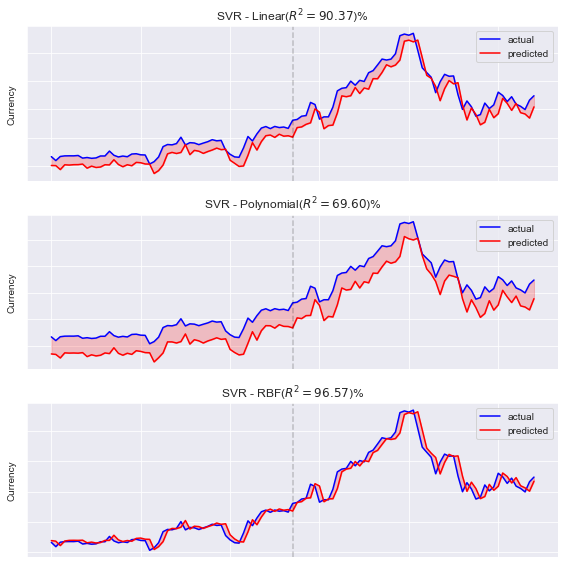

In [11]:
plot(results)